Downloading the trained models

In [1]:
!gdown --id 1Vp5t47ybD4GhO6nYUUsPszCht3BGqqpa
!gdown --id 1hmtjVoRVHzmCn_1qdAfl4zBlyP5C1vut

Downloading...
From: https://drive.google.com/uc?id=1Vp5t47ybD4GhO6nYUUsPszCht3BGqqpa
To: /content/Unet_model.zip
327MB [00:05, 62.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hmtjVoRVHzmCn_1qdAfl4zBlyP5C1vut
To: /content/CartoonData.zip
5.47MB [00:00, 20.7MB/s]


In [2]:
import zipfile
with zipfile.ZipFile('/content/Unet_model.zip', 'r') as zip_ref:
    zip_ref.extractall("./")

with zipfile.ZipFile('/content/CartoonData.zip', 'r') as zip_ref:
    zip_ref.extractall("./")


Importing required libraries

In [3]:
from tensorflow import keras
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import skimage.io as io
import cv2
import numpy as np


In [4]:
!pip install tf-slim

     |████████████████████████████████| 358kB 8.1MB/s 


loading required functions for running cartooning

In [5]:
import os
import uuid
import time
import subprocess
import sys

import cv2
import numpy as np
try:
    import tensorflow.compat.v1 as tf
except ImportError:
    import tensorflow as tf
class WB_Cartoonize:
    def __init__(self, weights_dir):
        if not os.path.exists(weights_dir):
            raise FileNotFoundError("Weights Directory not found, check path")
        self.load_model(weights_dir)
        print("Weights successfully loaded")
    
    def resize_crop(self, image):
        h, w, c = np.shape(image)
        if min(h, w) > 720:
            if h > w:
                h, w = int(720*h/w), 720
            else:
                h, w = 720, int(720*w/h)
        image = cv2.resize(image, (w, h),
                            interpolation=cv2.INTER_AREA)
        h, w = (h//8)*8, (w//8)*8
        image = image[:h, :w, :]
        return image

    def load_model(self, weights_dir):
        try:
            tf.disable_eager_execution()
        except:
            None

        tf.reset_default_graph()

        # [1, X,X,3]
        #[X,X,3]
        self.input_photo = tf.placeholder(tf.float32, [1, None, None, 3], name='input_image')
        network_out = unet_generator(self.input_photo)
        self.final_out = guided_filter(self.input_photo, network_out, r=1, eps=5e-3)

        all_vars = tf.trainable_variables()
        gene_vars = [var for var in all_vars if 'generator' in var.name]
        saver = tf.train.Saver(var_list=gene_vars)
        
        # if gpu:
        #     gpu_options = tf.GPUOptions(allow_growth=True)
        #     device_count = {'GPU':1}
        # else:
        #     gpu_options = None
        #     device_count = {'GPU':0}
        
        # config = tf.ConfigProto(gpu_options=gpu_options, device_count=device_count)
        
        # self.sess = tf.Session(config=config)
        self.sess = tf.Session()

        self.sess.run(tf.global_variables_initializer())
        saver.restore(self.sess, tf.train.latest_checkpoint(weights_dir))

    def infer(self, image):
        image = self.resize_crop(image)
        batch_image = image.astype(np.float32)/127.5 - 1
        batch_image = np.expand_dims(batch_image, axis=0)
        # [X,X,3]
        # [1,X,X,3]
        
        ## Session Run
        output = self.sess.run(self.final_out, feed_dict={self.input_photo: batch_image})
        
        ## Post Process
        output = (np.squeeze(output)+1)*127.5
        output = np.clip(output, 0, 255).astype(np.uint8)
        
        return output

In [6]:
def tf_box_filter(x, r):
    k_size = int(2*r+1)
    ch = x.get_shape().as_list()[-1]
    weight = 1/(k_size**2)
    box_kernel = weight*np.ones((k_size, k_size, ch, 1))
    box_kernel = np.array(box_kernel).astype(np.float32)
    output = tf.nn.depthwise_conv2d(x, box_kernel, [1, 1, 1, 1], 'SAME')
    return output

def guided_filter(x, y, r, eps=1e-2):
    
    x_shape = tf.shape(x)
    #y_shape = tf.shape(y)

    N = tf_box_filter(tf.ones((1, x_shape[1], x_shape[2], 1), dtype=x.dtype), r)

    mean_x = tf_box_filter(x, r) / N
    mean_y = tf_box_filter(y, r) / N
    cov_xy = tf_box_filter(x * y, r) / N - mean_x * mean_y
    var_x  = tf_box_filter(x * x, r) / N - mean_x * mean_x

    A = cov_xy / (var_x + eps)
    b = mean_y - A * mean_x

    mean_A = tf_box_filter(A, r) / N
    mean_b = tf_box_filter(b, r) / N

    output = tf.add(mean_A * x, mean_b, name='final_add')

    return output

In [7]:
try:
    import tensorflow.compat.v1 as tf
    import tf_slim as slim
except ImportError:
    import tensorflow as tf
    import tensorflow.contrib.slim as slim

import numpy as np



def resblock(inputs, out_channel=32, name='resblock'):
    
    with tf.variable_scope(name):
        
        x = slim.convolution2d(inputs, out_channel, [3, 3], 
                               activation_fn=None, scope='conv1')
        x = tf.nn.leaky_relu(x)
        x = slim.convolution2d(x, out_channel, [3, 3], 
                               activation_fn=None, scope='conv2')
        
        return x + inputs




def unet_generator(inputs, channel=32, num_blocks=4, name='generator', reuse=False):
    with tf.variable_scope(name, reuse=reuse):
        
        x0 = slim.convolution2d(inputs, channel, [7, 7], activation_fn=None)
        x0 = tf.nn.leaky_relu(x0)
        
        x1 = slim.convolution2d(x0, channel, [3, 3], stride=2, activation_fn=None)
        x1 = tf.nn.leaky_relu(x1)
        x1 = slim.convolution2d(x1, channel*2, [3, 3], activation_fn=None)
        x1 = tf.nn.leaky_relu(x1)
        
        x2 = slim.convolution2d(x1, channel*2, [3, 3], stride=2, activation_fn=None)
        x2 = tf.nn.leaky_relu(x2)
        x2 = slim.convolution2d(x2, channel*4, [3, 3], activation_fn=None)
        x2 = tf.nn.leaky_relu(x2)
        
        for idx in range(num_blocks):
            x2 = resblock(x2, out_channel=channel*4, name='block_{}'.format(idx))
            
        x2 = slim.convolution2d(x2, channel*2, [3, 3], activation_fn=None)
        x2 = tf.nn.leaky_relu(x2)
        
        h1, w1 = tf.shape(x2)[1], tf.shape(x2)[2]
        x3 = tf.image.resize_bilinear(x2, (h1*2, w1*2))
        x3 = slim.convolution2d(x3+x1, channel*2, [3, 3], activation_fn=None)
        x3 = tf.nn.leaky_relu(x3)
        x3 = slim.convolution2d(x3, channel, [3, 3], activation_fn=None)
        x3 = tf.nn.leaky_relu(x3)

        h2, w2 = tf.shape(x3)[1], tf.shape(x3)[2]
        x4 = tf.image.resize_bilinear(x3, (h2*2, w2*2))
        x4 = slim.convolution2d(x4+x0, channel, [3, 3], activation_fn=None)
        x4 = tf.nn.leaky_relu(x4)
        x4 = slim.convolution2d(x4, 3, [7, 7], activation_fn=None)
        
        return x4

Loading the trained model

In [ ]:
wb_cartoonizer = WB_Cartoonize(os.path.abspath("/content/CartoonData"))

In [9]:
model = keras.models.load_model("/content/Unet_model/")

Running the model

1.jpg
(1638, 1638, 3)


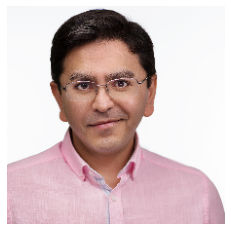

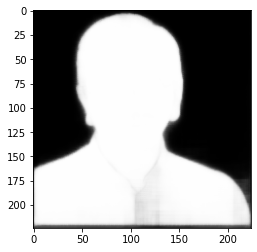

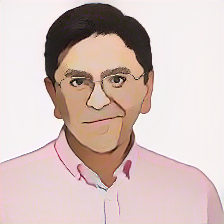

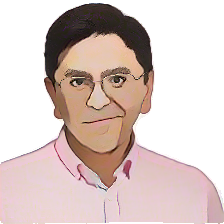

1.jpg
6.jpg
(402, 715, 3)


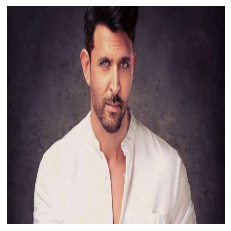

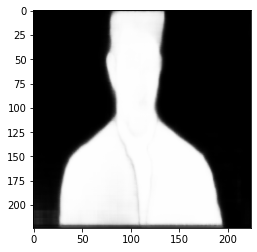

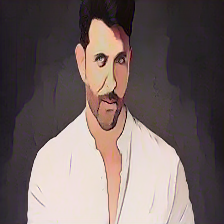

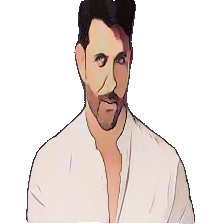

6.jpg
8.jpg
(2769, 3823, 3)


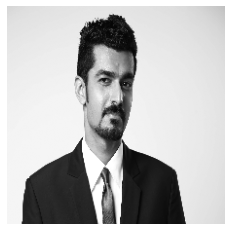

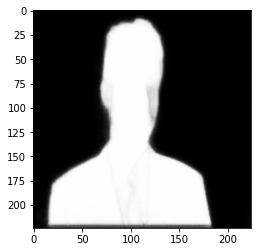

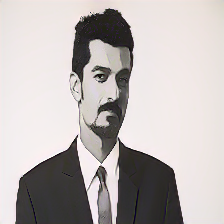

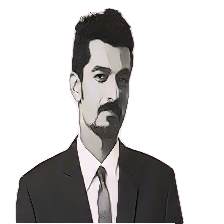

8.jpg
3.jpg
(1024, 1024, 3)


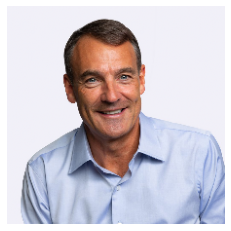

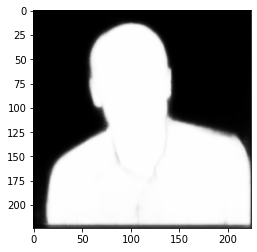

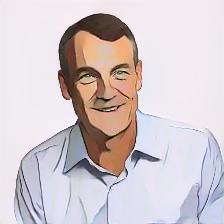

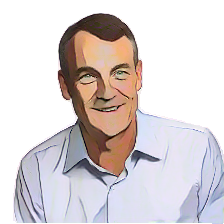

3.jpg
10.jpg
(1919, 2880, 3)


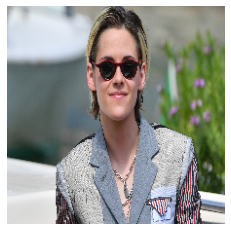

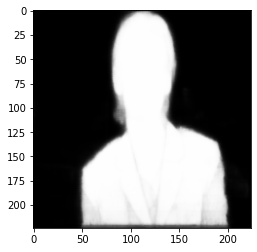

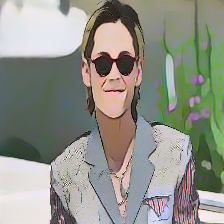

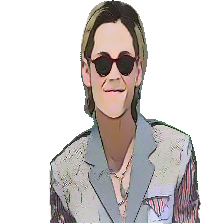

10.jpg
9.jpg
(183, 275, 3)


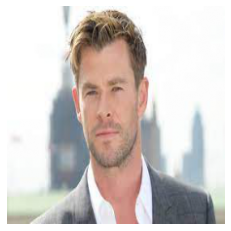

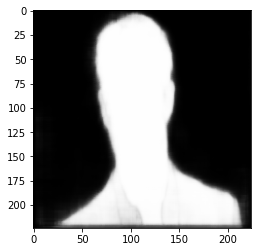

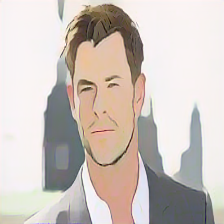

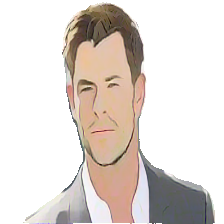

9.jpg
4.jpg
(800, 800, 3)


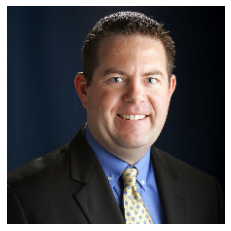

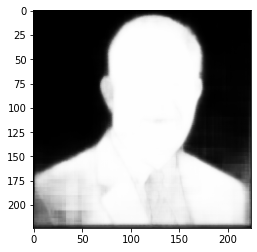

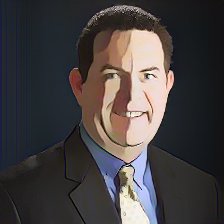

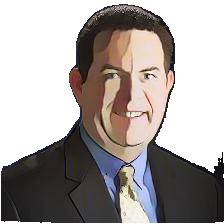

4.jpg
2.jpg
(400, 400, 3)


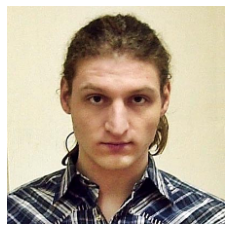

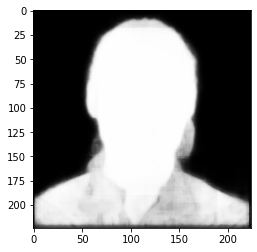

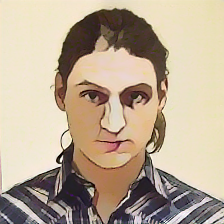

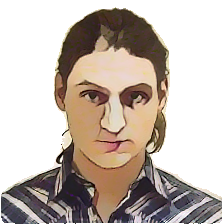

2.jpg
7.jpg
(433, 758, 3)


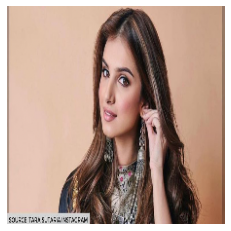

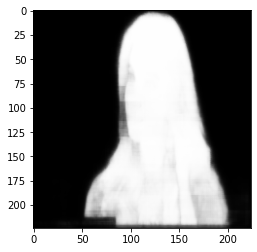

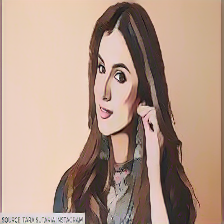

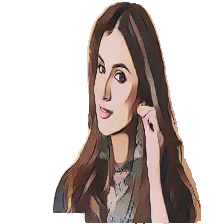

7.jpg
5.jpg
(450, 600, 3)


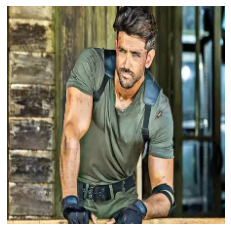

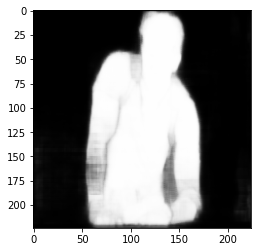

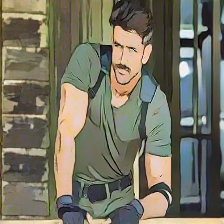

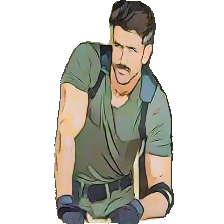

5.jpg


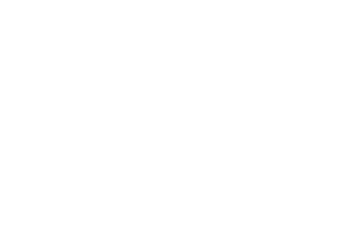

In [82]:

ima = os.listdir("/content/Input")
for i in ima:
    if i.split(".")[-1] == "jpg":
        print(i)
        I = io.imread("/content/Input/"+i)
        Fin_img = cv2.resize(I, (224,224))
        print(I.shape)
        Fin_img.shape
        Fin_img = Fin_img/255.0
        imgs = Fin_img
        plt.axis('off')
        plt.imshow(Fin_img)
        plt.show()
        Fin_img = np.expand_dims(Fin_img, 0)
        Fin_img.shape
        result = model.predict(Fin_img)
        a = np.squeeze(result, axis=0)
        stacked_img = np.stack((a,)*3, axis=-2)
        stacked_img = np.squeeze(stacked_img, axis=-1)
        plt.imshow(stacked_img)
        plt.show()
        b= list(a)
        plt.axis('off')
        am = cv2.imread("/content/Input/"+i)
        am = cv2.resize(am, (224,224))
        cartoon_image = wb_cartoonizer.infer(am)
        from google.colab.patches import cv2_imshow
        cv2_imshow(cartoon_image)
        cv2.waitKey(0)
        fi = np.zeros([224,224,3])
        for x in range(len(b)):
            for y in range(len(b[x])):
                if b[x][y] < 0.25:
                    fi[x][y][0] = 255
                    fi[x][y][1] = 255
                    fi[x][y][2] = 255
                else:
                    fi[x][y][0] = cartoon_image[x][y][0]
                    fi[x][y][1] = cartoon_image[x][y][1]
                    fi[x][y][2] = cartoon_image[x][y][2]
        cv2_imshow(fi)
        print(i)
        cv2.imwrite("/content/Output/"+i.split(".")[0]+".jpg", fi)